<a href="https://colab.research.google.com/github/CriticalDatathon/team-7/blob/main/workshop_3_working_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a target="_blank" href="https://colab.research.google.com/github/CriticalDatathon/workshops/blob/main/workshop_3.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Workshop 3: Let's get our model!

**🎨 Team 7__**

`Add your team number above`

**👥 Authors**

`Add your names here (alphabetically)`


* Charles
* Chenyu
* Ikakke
* Shyla
* Joey
* Pedro
* Peter

**🎯 Goals of this Workshop**
1. Understand the best way to split the data into train and test
2. Define the performance metrics that you are going to use in the evaluation of your model 
3. Develop a machine learning (ML) model to either:
  - predict $SaO_2$ values -> regression
  - predict the gap between $SaO_2$ and $SpO_2$ -> regression
  - detect cases of Hidden Hypoxemia (HH) -> classification

  The developed model can either be linear or non-linear.
4. Implement grid-search to further optimize parameters.
5. Assess what were the most relevant features for the regression/classification.


**✏️ Expected Deliverables**
 - Developed models with the performance metrics and feature importance properly reported.



**❗ Highlighted Pitfall(s)**
- Outcome leakage
- Suboptimal metrics for model evaluation
- No improvement compared to the presented baseline / Models not learning
- Overly complex models

## Table of Contents

1. Library imports
2. Implement an ML pipeline with grid-search parameter tunning
3. Model Evaluation (using meaningful metrics and assessing feature importance)

## 1. Setup Environment

You can add more libraries if you are familiar with them for your own model. But use these packages for the first part only.

In [ ]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/MIT_Datathon_2023
import pandas as pd
df = pd.read_csv("./data_3.csv")


/content/drive/MyDrive/MIT_Datathon_2023


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 7.6 MB/s eta 0:00:00


In [ ]:
!pip install yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Data reading in Dataframe format and data preprocessing
import pandas as pd
pd.set_option("display.max_columns", 160)
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset Creation
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV

# Dataset Processing
from sklearn import datasets, linear_model, metrics
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Model Development
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge 
from sklearn.svm import SVC

# Model Evaluation
from sklearn.metrics import r2_score, confusion_matrix, ConfusionMatrixDisplay
from yellowbrick.classifier import ClassificationReport, ClassPredictionError
from yellowbrick.regressor import ResidualsPlot, PredictionError

# Feature Importance
import shap


# Team 7 exploration 

In [ ]:
import pandas as pd 
df = pd.read_csv("data_3.csv")


In [ ]:
df.columns

Index(['Unnamed: 0', 'subject_id', 'stay_id', 'SaO2_timestamp', 'SaO2',
       'delta_SpO2', 'SpO2', 'hidden_hypoxemia', 'hadm_id', 'gender',
       ...
       'delta_resp_rate', 'resp_rate', 'delta_temperature', 'temperature',
       'delta_glucose', 'glucose', 'delta_heart_rhythm', 'heart_rhythm',
       'SaO2-SpO2', 'HH_study'],
      dtype='object', length=141)

In [ ]:
# filter out columns has timestamp 
df_1 = df[df.columns.drop(list(df.filter(regex='timestamp')))]
df_1 = df_1[df_1.columns.drop(list(df_1.filter(regex='id')))]

In [ ]:
df_1.head()

,Unnamed: 0,SaO2,delta_SpO2,SpO2,gender,sex_female,anchor_age,race,race_group,language,insurance,weight,height,BMI,anchor_year_group,first_hosp_stay,first_icu_stay,icustay_seq,admittime,dischtime,icu_intime,icu_outtime,los_hospital,los_icu,CCI,SOFA_admission,mortality_in,delta_vent_start,ventilation_status,invasive_vent,delta_FiO2,FiO2,delta_rrt,rrt,delta_vp_start,norepinephrine_equivalent_dose,delta_sofa_coag,sofa_coag,delta_sofa_liver,sofa_liver,delta_sofa_cv,sofa_cv,delta_sofa_cns,sofa_cns,delta_sofa_renal,sofa_renal,delta_sofa_resp,sofa_resp,delta_hemoglobin,hemoglobin,delta_hematocrit,hematocrit,delta_mch,mch,delta_mchc,mchc,delta_mcv,mcv,delta_platelet,platelet,delta_rbc,rbc,delta_rdw,rdw,delta_wbc,wbc,delta_d_dimer,d_dimer,delta_fibrinogen,fibrinogen,delta_thrombin,thrombin,delta_inr,inr,delta_pt,pt,delta_ptt,ptt,delta_alt,alt,delta_alp,alp,delta_ast,ast,delta_bilirubin_total,bilirubin_total,delta_bilirubin_direct,bilirubin_direct,delta_bilirubin_indirect,bilirubin_indirect,delta_ck_cpk,ck_cpk,delta_ck_mb,ck_mb,delta_ggt,ggt,delta_ld_ldh,ld_ldh,delta_albumin,albumin,delta_aniongap,aniongap,delta_bicarbonate,bicarbonate,delta_bun,bun,delta_calcium,calcium,delta_creatinine,creatinine,delta_glucose_lab,glucose_lab,delta_sodium,sodium,delta_potassium,potassium,delta_ph,ph,delta_lactate,lactate,delta_heart_rate,heart_rate,delta_mbp,mbp,delta_resp_rate,resp_rate,delta_temperature,temperature,delta_glucose,glucose,delta_heart_rhythm,heart_rhythm,SaO2-SpO2,HH_study
0,0,90.0,-4,89,F,1,68,BLACK/AFRICAN AMERICAN,Black,ENGLISH,Medicare,65.0,157.0,26.370238,2008 - 2010,True,True,1,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-11 04:20:05,2131-01-20 08:27:30,13,9.17,5,8,1,-4.0,NonInvasiveVent,0,0.0,40.0,NaN,0,NaN,NaN,476.0,1.0,-1024.0,0.0,-4,0,-64.0,0.0,-4.0,0.0,56.0,2.0,445.0,10.2,445.0,33.4,445.0,28.3,445.0,30.5,445.0,93.0,445.0,144.0,445.0,3.61,445.0,17.5,445.0,17.1,NaN,NaN,3656.0,339.0,NaN,NaN,-222.0,1.1,-222.0,12.4,-222.0,44.0,-1050.0,116.0,-1050.0,48.0,-1050.0,55.0,-1050.0,0.2,NaN,NaN,NaN,NaN,1804.0,786.0,-2313.0,14.0,NaN,NaN,-388239.0,260.0,-2313.0,3.5,445.0,15.0,445.0,31.0,445.0,32.0,445.0,8.9,445.0,1.2,445.0,199.0,445.0,135.0,445.0,5.8,0.0,7.38,0.0,1.1,-4,78.0,-3,96.0,-4.0,19.5,-64.0,36.72,445.0,199.0,-4.0,SR (Sinus Rhythm),1.0,0
1,2,99.0,0,99,F,1,53,OTHER,Other,ENGLISH,Medicare,96.0,157.0,38.946813,2008 - 2010,True,True,1,2160-05-18 07:45:00,2160-05-23 13:30:00,2160-05-18 10:00:53,2160-05-19 17:33:33,5,1.29,7,4,0,-123.0,InvasiveVent,1,0.0,50.0,NaN,0,NaN,NaN,-63.0,0.0,NaN,NaN,-3,0,57.0,0.0,-63.0,0.0,57.0,1.0,-85.0,11.2,-85.0,31.9,-85.0,33.9,-85.0,35.1,-85.0,97.0,-85.0,254.0,-85.0,3.30,-85.0,13.1,-85.0,20.2,NaN,NaN,-182.0,212.0,NaN,NaN,-85.0,1.0,-85.0,11.3,-85.0,27.2,-23403.0,14.0,-23403.0,50.0,-23403.0,17.0,-23403.0,0.5,-23403.0,0.2,-23403.0,0.3,-23403.0,52.0,76302.0,3.0,NaN,NaN,2901677.0,170.0,-23403.0,3.6,-85.0,12.0,-85.0,23.0,-85.0,16.0,-23403.0,8.1,-85.0,1.1,717.0,98.0,-85.0,140.0,-85.0,4.0,0.0,7.33,-181.0,2.6,-3,92.0,-3,86.5,-2.0,14.0,-3.0,36.90,0.0,155.0,-3.0,SR (Sinus Rhythm),0.0,0
2,8,97.0,0,100,F,1,80,WHITE,White,ENGLISH,Medicare,43.0,NaN,NaN,2011 - 2013,True,False,2,2156-04-12 14:16:00,2156-04-29 16:26:00,2156-04-19 18:11:19,2156-04-26 18:58:41,17,7.00,6,10,0,-286.0,InvasiveVent,1,0.0,40.0,NaN,0,-225.0,0.1500,194.0,0.0,194.0,0.0,14,1,-46.0,0.0,194.0,0.0,14.0,2.0,164.0,9.9,164.0,31.7,164.0,30.2,164.0,31.1,164.0,97.0,164.0,183.0,164.0,3.27,164.0,14.3,164.0,13.2,NaN,NaN,30897.0,393.0,NaN,NaN,164.0,1.0,164.0,10.5,164.0,25.5,164.0,63.0,164.0,145.0,164.0,102.0,164.0,0.1,NaN,NaN,NaN,NaN,164.0,55.0,164.0,5.0,NaN,NaN,164.0,329.0,10454.0,2.1,164.0,10.0,164.0,26.0,164.0,31.0,164.0,8.3,164.0,0.5,164.0,163.0,164.0,143.0,164.0,4.4,0.0,7.38,0.0,2.0,-1,99.0,-1,68.0,-1.0,18.0,14.0,36.94,164.0,163.0,14.0,SR (Sinus Rhythm),-3.0,0
3,11,98.0,-3,100,F,1,80,WHITE,White,ENGLISH,Medicare,43.0,NaN,NaN,2011 - 2013,True,False,2,2156-04-12 14:16:00,2156-04-29 16:26:00,2156-04-19 18:11:19,2156-04-26 18:58:41,17,7.00,6,10,0,-1820.0,InvasiveVen

In [ ]:
# import numpy as np
# i = 0
# np.corrcoef(X.iloc[:,i:i+1], y)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GroupShuffleSplit 

# Encode categorical variables
le = LabelEncoder()

for col in df_1.columns:
  # print(col)
  df_1[col] = le.fit_transform(df_1[col].astype(str))

# Impute missing values
imputer = SimpleImputer(strategy='mean')
df_1 = pd.DataFrame(imputer.fit_transform(df_1), columns=df_1.columns)

# Split the data into training and test sets


splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 42)
split = splitter.split(df_1, groups=df['hadm_id'])
train_inds, test_inds = next(split)

train = df_1.iloc[train_inds]
test = df_1.iloc[test_inds]


# Split the data into features (X) and the target variable (y)
X_train = train.iloc[:,3:-2]
y_train = train.iloc[:,-1:] # label  HH Study 
y2_train = train.iloc[:,-2:-1] # label SaO2-SpO2
X_test = test.iloc[:,3:-2]
y_test = test.iloc[:,-1:]
y2_test = test.iloc[:,-2:-1] # label SaO2-SpO2

In [ ]:

# Split the data into features (X) and the target variable (y)
X_train = train.iloc[:,3:-2]
y_train = train.iloc[:,-1:] # label  HH Study 
y2_train = train.iloc[:,-2:-1] # label SaO2-SpO2
X_test = test.iloc[:,3:-2]
y_test = test.iloc[:,-1:]
y2_test = test.iloc[:,-2:-1] # label SaO2-SpO2

### All features  - LinearRegression

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,recall_score
# Define preprocessing for numeric columns (scale them)
numeric_features = X_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode them)
categorical_features = X_train.select_dtypes(exclude=['int64','float64']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LinearRegression())])

# Fit the pipeline to train a logistic regression model on the dataset
pipeline.fit(X_train, y_train)

# You can also use the pipeline to make predictions
y_pred = pipeline.predict(X_test)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Root Mean Squared Error (RMSE)
rmse = sqrt(mse)

# R-squared
r2 = r2_score(y_test, y_pred)

print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared:', r2)



Mean Absolute Error (MAE): 0.03943598863798078
Mean Squared Error (MSE): 0.015408771169001578
Root Mean Squared Error (RMSE): 0.12413207147631743
R-squared: 0.016115485799717444


### All features- Classification 

In [ ]:
# Define the model
model = LogisticRegression()

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model 
clf.fit(X_train, y2_train)

# Preprocessing of validation data, get predictions
y2_pred = clf.predict(X_test)

# Evaluate the model
print('Model accuracy: ', accuracy_score(y_test, y2_pred))
print('Model recall:', recall_score(y_test, y2_pred,average='micro'))
print('Model F1:', f1_score(y_test, y2_pred ,average='micro'))


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Model accuracy:  0.30133055048265067
Model recall: 0.30133055048265067
Model F1: 0.30133055048265067


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


### RFE feature selection  - regression

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression,LinearRegression
rfe_selector = RFE(estimator=LinearRegression(), n_features_to_select=15, step=10, verbose=5)
rfe_selector.fit(X_train, y2_train)
rfe_support = rfe_selector.get_support()
rfe_feature_reg = X_train.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature_reg)), 'selected features')

Fitting estimator with 129 features.
Fitting estimator with 119 features.
Fitting estimator with 109 features.
Fitting estimator with 99 features.
Fitting estimator with 89 features.
Fitting estimator with 79 features.
Fitting estimator with 69 features.
Fitting estimator with 59 features.
Fitting estimator with 49 features.
Fitting estimator with 39 features.
Fitting estimator with 29 features.
Fitting estimator with 19 features.
15 selected features


In [ ]:
rfe_feature_reg

['race_group',
 'insurance',
 'anchor_year_group',
 'first_hosp_stay',
 'first_icu_stay',
 'icustay_seq',
 'icu_outtime',
 'mortality_in',
 'ventilation_status',
 'invasive_vent',
 'rrt',
 'sofa_coag',
 'sofa_liver',
 'sofa_renal',
 'sofa_resp']

### RFE - Classification

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression,LinearRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=15, step=10, verbose=5)
rfe_selector.fit(X_train, y_train)
rfe_support = rfe_selector.get_support()
rfe_feature_class = X_train.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature_class)), 'selected features')

Fitting estimator with 129 features.


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Fitting estimator with 119 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Fitting estimator with 109 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Fitting estimator with 99 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Fitting estimator with 89 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Fitting estimator with 79 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Fitting estimator with 69 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Fitting estimator with 59 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Fitting estimator with 49 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Fitting estimator with 39 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Fitting estimator with 29 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

Fitting estimator with 19 features.
15 selected features


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
rfe_feature_class

['SpO2',
 'height',
 'FiO2',
 'sofa_resp',
 'hematocrit',
 'mch',
 'mchc',
 'rbc',
 'thrombin',
 'creatinine',
 'potassium',
 'ph',
 'heart_rate',
 'delta_mbp',
 'resp_rate']

### 

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer

# Select the features
features = ['SpO2',
              'race_group',
              'language',
              'insurance',
              'anchor_year_group',
              'first_hosp_stay',
              'first_icu_stay',
              'icustay_seq',
              'mortality_in',
              'invasive_vent',
              'rrt',
              'sofa_coag',
              'sofa_liver',
              'sofa_cns',
              'sofa_resp']
X_rfe = df_1[features]
y = df_1['SaO2-SpO2']  

# Use mean imputation for missing values
imputer = SimpleImputer(strategy='mean')
X_rfe = imputer.fit_transform(X_rfe)

# Create an SVM model
# model = LinearRegression()
model = SVR()

# Use K-fold cross-validation to get a more robust estimate of the model performance
cv = KFold(n_splits=5)

scores = cross_val_score(model, X_rfe, y, cv=cv, scoring='neg_mean_squared_error')

# The scores are negative because sklearn always tries to maximize the score, so loss functions like MSE are negated.
# We take the negative of the scores to get positive MSE values.
mse_scores = -scores

print('Cross-validation MSE: %.3f +/- %.3f' % (mse_scores.mean(), mse_scores.std()))


Cross-validation MSE: 157.793 +/- 3.655


#### All features 

In [ ]:

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest


# This dataset is way too high-dimensional. Better do PCA:
pca = PCA(n_components=10)

# Maybe some original features were good, too?
selection = SelectKBest(k=5)

# Build estimator from PCA and Univariate selection:

combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset:
X_features = combined_features.fit(X_train, y_train).transform(X_train)
print("Combined space has", X_features.shape[1], "features")

svm = SVC(kernel="linear")

# Do grid search over k, n_components and C:

pipeline = Pipeline([("features", combined_features), ("svm", svm)])

param_grid = dict(
    features__pca__n_components=[1, 2, 3],
    features__univ_select__k=[1, 2],
    svm__C=[0.1, 1, 10],
)

grid_search = GridSearchCV(pipeline, param_grid=param_grid, verbose=10)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Combined space has 15 features
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5; 1/18] START features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 1/5; 1/18] END features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1;, score=0.983 total time= 3.2min
[CV 2/5; 1/18] START features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 2/5; 1/18] END features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1;, score=0.983 total time= 3.0min
[CV 3/5; 1/18] START features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 3/5; 1/18] END features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1;, score=0.984 total time= 3.0min
[CV 4/5; 1/18] START features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 4/5; 1/18] END features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1;, score=0.984 total time= 2.7min
[CV 5/5; 1/18] START features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 5/5; 1/18] END features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1;, score=0.983 total time= 2.5min
[CV 1/5; 2/18] START features__pca__n_components=1, features__univ_select__k=1, svm__C=1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 1/5; 2/18] END features__pca__n_components=1, features__univ_select__k=1, svm__C=1;, score=0.983 total time= 3.6min
[CV 2/5; 2/18] START features__pca__n_components=1, features__univ_select__k=1, svm__C=1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 2/5; 2/18] END features__pca__n_components=1, features__univ_select__k=1, svm__C=1;, score=0.983 total time= 3.5min
[CV 3/5; 2/18] START features__pca__n_components=1, features__univ_select__k=1, svm__C=1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 3/5; 2/18] END features__pca__n_components=1, features__univ_select__k=1, svm__C=1;, score=0.984 total time= 2.8min
[CV 4/5; 2/18] START features__pca__n_components=1, features__univ_select__k=1, svm__C=1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 4/5; 2/18] END features__pca__n_components=1, features__univ_select__k=1, svm__C=1;, score=0.984 total time= 3.1min
[CV 5/5; 2/18] START features__pca__n_components=1, features__univ_select__k=1, svm__C=1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 5/5; 2/18] END features__pca__n_components=1, features__univ_select__k=1, svm__C=1;, score=0.983 total time= 3.2min
[CV 1/5; 3/18] START features__pca__n_components=1, features__univ_select__k=1, svm__C=10


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 1/5; 3/18] END features__pca__n_components=1, features__univ_select__k=1, svm__C=10;, score=0.983 total time= 3.2min
[CV 2/5; 3/18] START features__pca__n_components=1, features__univ_select__k=1, svm__C=10


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 2/5; 3/18] END features__pca__n_components=1, features__univ_select__k=1, svm__C=10;, score=0.983 total time= 3.0min
[CV 3/5; 3/18] START features__pca__n_components=1, features__univ_select__k=1, svm__C=10


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 3/5; 3/18] END features__pca__n_components=1, features__univ_select__k=1, svm__C=10;, score=0.984 total time= 3.4min
[CV 4/5; 3/18] START features__pca__n_components=1, features__univ_select__k=1, svm__C=10


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 4/5; 3/18] END features__pca__n_components=1, features__univ_select__k=1, svm__C=10;, score=0.984 total time= 3.2min
[CV 5/5; 3/18] START features__pca__n_components=1, features__univ_select__k=1, svm__C=10


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 5/5; 3/18] END features__pca__n_components=1, features__univ_select__k=1, svm__C=10;, score=0.983 total time= 2.9min
[CV 1/5; 4/18] START features__pca__n_components=1, features__univ_select__k=2, svm__C=0.1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 1/5; 4/18] END features__pca__n_components=1, features__univ_select__k=2, svm__C=0.1;, score=0.983 total time= 3.6min
[CV 2/5; 4/18] START features__pca__n_components=1, features__univ_select__k=2, svm__C=0.1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 2/5; 4/18] END features__pca__n_components=1, features__univ_select__k=2, svm__C=0.1;, score=0.983 total time= 2.6min
[CV 3/5; 4/18] START features__pca__n_components=1, features__univ_select__k=2, svm__C=0.1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 3/5; 4/18] END features__pca__n_components=1, features__univ_select__k=2, svm__C=0.1;, score=0.984 total time= 3.2min
[CV 4/5; 4/18] START features__pca__n_components=1, features__univ_select__k=2, svm__C=0.1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 4/5; 4/18] END features__pca__n_components=1, features__univ_select__k=2, svm__C=0.1;, score=0.984 total time= 2.9min
[CV 5/5; 4/18] START features__pca__n_components=1, features__univ_select__k=2, svm__C=0.1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 5/5; 4/18] END features__pca__n_components=1, features__univ_select__k=2, svm__C=0.1;, score=0.983 total time= 2.5min
[CV 1/5; 5/18] START features__pca__n_components=1, features__univ_select__k=2, svm__C=1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 1/5; 5/18] END features__pca__n_components=1, features__univ_select__k=2, svm__C=1;, score=0.983 total time= 3.0min
[CV 2/5; 5/18] START features__pca__n_components=1, features__univ_select__k=2, svm__C=1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 2/5; 5/18] END features__pca__n_components=1, features__univ_select__k=2, svm__C=1;, score=0.983 total time= 3.3min
[CV 3/5; 5/18] START features__pca__n_components=1, features__univ_select__k=2, svm__C=1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 3/5; 5/18] END features__pca__n_components=1, features__univ_select__k=2, svm__C=1;, score=0.984 total time= 3.7min
[CV 4/5; 5/18] START features__pca__n_components=1, features__univ_select__k=2, svm__C=1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 4/5; 5/18] END features__pca__n_components=1, features__univ_select__k=2, svm__C=1;, score=0.984 total time= 2.7min
[CV 5/5; 5/18] START features__pca__n_components=1, features__univ_select__k=2, svm__C=1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 5/5; 5/18] END features__pca__n_components=1, features__univ_select__k=2, svm__C=1;, score=0.983 total time= 2.5min
[CV 1/5; 6/18] START features__pca__n_components=1, features__univ_select__k=2, svm__C=10


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 1/5; 6/18] END features__pca__n_components=1, features__univ_select__k=2, svm__C=10;, score=0.983 total time= 3.4min
[CV 2/5; 6/18] START features__pca__n_components=1, features__univ_select__k=2, svm__C=10


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 2/5; 6/18] END features__pca__n_components=1, features__univ_select__k=2, svm__C=10;, score=0.983 total time= 3.6min
[CV 3/5; 6/18] START features__pca__n_components=1, features__univ_select__k=2, svm__C=10


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 3/5; 6/18] END features__pca__n_components=1, features__univ_select__k=2, svm__C=10;, score=0.984 total time= 2.7min
[CV 4/5; 6/18] START features__pca__n_components=1, features__univ_select__k=2, svm__C=10


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 4/5; 6/18] END features__pca__n_components=1, features__univ_select__k=2, svm__C=10;, score=0.984 total time= 3.1min
[CV 5/5; 6/18] START features__pca__n_components=1, features__univ_select__k=2, svm__C=10


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 5/5; 6/18] END features__pca__n_components=1, features__univ_select__k=2, svm__C=10;, score=0.983 total time= 3.5min
[CV 1/5; 7/18] START features__pca__n_components=2, features__univ_select__k=1, svm__C=0.1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 1/5; 7/18] END features__pca__n_components=2, features__univ_select__k=1, svm__C=0.1;, score=0.983 total time=14.6min
[CV 2/5; 7/18] START features__pca__n_components=2, features__univ_select__k=1, svm__C=0.1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[CV 2/5; 7/18] END features__pca__n_components=2, features__univ_select__k=1, svm__C=0.1;, score=0.983 total time=10.4min
[CV 3/5; 7/18] START features__pca__n_components=2, features__univ_select__k=1, svm__C=0.1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


### PCA Pipeline Regression 

# Example code

## 2. Split dataset into train and test

Before any data standardization, it is crucial to split the data into two groups, training and testing (so that there is no data leakage). To start, we will put 70% of our data into our training set, and 30% of our data into the testing set. Feel free to try other train/test splits, such as 75%/25%, or 80%/20%.

You might also want to ensure that minority groups are represented in both train and test sets. For that, you can use more specific train-test-split methods, read more about it [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split). Or split according to the time someone entered the hospital (important if policies change).

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GroupShuffleSplit 

# Encode categorical variables
le = LabelEncoder()

for col in df.columns:
  # print(col)
  df[col] = le.fit_transform(df[col].astype(str))

# Impute missing values
imputer = SimpleImputer(strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Split the data into training and test sets


splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 42)
split = splitter.split(df, groups=df['hadm_id'])
train_inds, test_inds = next(split)

df_train = df.iloc[train_inds]
df_test = df.iloc[test_inds]


# # Split the data into features (X) and the target variable (y)
# X_train = train.iloc[:,3:-2]
# y_train = train.iloc[:,-1:] # label  HH Study 
# y2_train = train.iloc[:,-2:-1] # label SaO2-SpO2
# X_test = test.iloc[:,3:-2]
# y_test = test.iloc[:,-1:]
# y2_test = test.iloc[:,-2:-1] # label SaO2-SpO2

###### ✏️ Set your path to the dataset 

In [ ]:
# df_train = pd.read_csv('/content/drive/MyDrive/train.csv')
# df_test = pd.read_csv('/content/drive/MyDrive/test.csv')
# df_train.head(2)

###### ✏️ Split your labels from the remaining dataset

In [ ]:
# label_cols=['hidden_hypoxemia', 'SaO2']
label_cols=['HH_study','SaO2-SpO2']

y_train = df_train[label_cols]
X_train = df_train.drop(columns=label_cols)

y_test = df_test[label_cols]
X_test = df_test.drop(columns=label_cols)

### Get label vectors for both possibilities: regression and classification

If you want to use regression or classification, the labels used to train the model will be different. In the case of regression, you will have a numerical variables with SaO2 values, whereas in classification you need to define classes for hidden hypoxemia.

In [ ]:
y2_train

,SaO2-SpO2
0,35.0
1,33.0
2,24.0
3,13.0
4,13.0
...,...
19495,41.0
19496,24.0
19497,13.0
19498,13.0


In [ ]:
y_train_c = y_train[['HH_study']].values
y_test_c = y_test[['HH_study']].values
y_train_r = y2_train[['SaO2-SpO2']].values
y_test_r = y2_test[['SaO2-SpO2']].values

###### ✏️ Define label vectors for chosen ML approaches

In [ ]:
# Code here!

## 3. Implement ML Pipeline

### 3.1 Naive Model Implementation

What would our accuracy be if we predicted the most likely class? In this case, our prediction would simply be 1 or 0 for every patient. Using our training dataset we can create a naive model that predicts the most likely class for every patient.


In [ ]:
if np.sum(y_train_c == 0):
    y_preds_cc = [1 for _ in range(len(y_test_c))]
else:
    y_preds_cc = [0 for _ in range(len(y_test_c))]

# Check accuracy score
accuracy_score = np.mean(y_preds_cc == y_test_c)
print("Accuracy: {:.4f}".format(accuracy_score))

Accuracy: 0.0159


###### ✏️ Test a naive approach to have a performance baseline

In [ ]:
# Code here!

### 3.2 Data Normalization

Many machine learning models are directly influenced by the scale of the features that you input to the model. Therefore, it is important to normalize the scale of values used in your pipeline.

One of the most common methods used is data standardization, but the decision should be taken considering the specific use case or model that you are developing. If you are curious, you can further read about this topic [here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py).

It is important to consider that in a dataset one might have several types of variables: categorical, continuous, binary. For both categorical and binary variables, it is not a good practice to apply standardization methods. Therefore, it is important to distinguish the different type of variables that one might have and apply normalization methods only to those that make sense.

In [ ]:
feats = X_train.columns
for feat in feats:
  print(feat)
  print(X_train[feat].value_counts())

SpO2
0.0     5074
12.0    1941
11.0    1909
10.0    1623
9.0     1397
8.0     1116
7.0      852
6.0      608
5.0      413
4.0      303
3.0      199
2.0      120
1.0      112
Name: SpO2, dtype: int64
gender
1.0    10082
0.0     5585
Name: gender, dtype: int64
sex_female
0.0    10082
1.0     5585
Name: sex_female, dtype: int64
anchor_age
54.0    564
49.0    552
52.0    545
55.0    488
50.0    483
       ... 
2.0      17
8.0      13
1.0       8
3.0       7
0.0       3
Name: anchor_age, Length: 73, dtype: int64
race
28.0    10164
27.0     1848
7.0       912
22.0      481
31.0      408
26.0      343
3.0       177
18.0      177
23.0      137
1.0       128
10.0      113
32.0      108
14.0      107
8.0        93
2.0        84
24.0       78
9.0        51
0.0        41
15.0       35
6.0        32
29.0       29
5.0        26
21.0       21
30.0       21
13.0       15
20.0        8
19.0        8
12.0        7
25.0        6
4.0         5
17.0        2
16.0        1
11.0        1
Name: race, dtype: i

In [ ]:
binary_variables=['invasive_vent', 'language', 'gender', 'rrt', 'mortality_in', 'invasive_vent',  'NonInvasiveVent', 'None_ventilatio']

In [ ]:
X_train.shape

(15569, 139)

In [ ]:
# X_train_continuous = X_train.drop(columns=binary_variables)
# X_test_continuous = X_test.drop(columns=binary_variables)
# X_train_binary = X_train[binary_variables]
# X_test_binary = X_test[binary_variables]

In [ ]:
preprocessor = make_pipeline(StandardScaler())

preprocessor

Pipeline(steps=[('standardscaler', StandardScaler())])

In [ ]:
# train_preprocessed = preprocessor.fit_transform(X_train_continuous)
# pd.DataFrame(train_preprocessed, columns=preprocessor.get_feature_names_out())

In [ ]:
# test_preprocessed = preprocessor.transform(X_test_continuous)

Join the processed continuous variables with the binary ones to then feed to the model.

In [ ]:
# X_train_processed=pd.concat([X_train_binary, pd.DataFrame(train_preprocessed, columns=preprocessor.get_feature_names_out())], axis=1, join='inner')
# X_test_processed=pd.concat([X_test_binary, pd.DataFrame(test_preprocessed, columns=preprocessor.get_feature_names_out())], axis=1, join='inner')

Note: After transforming your data, it is important to further explore it's distribution and ensure that the transformations applied make sense and resulted on what was expected.

###### ✏️ Implement your own data normalization strategy

In [ ]:
# Code here!


# Check your normalization, e.g. summary statistics, histograms, scatter plots, etc.



### 3.3 Linear Regression Baseline

On of the easiest Machine Learning model is **linear regression**. It assumes that the target variable can be written as a linear combination of the features.

In many problems, this solution can be a very strong baseline. Thanks to its simplicity, it can be fitted very quickly even when the number of features is high. 

In general, wrapping together the features, preprocessing and fitting the estimator in a single pipeline makes it easier to transform, fit and predict the data.

In [ ]:
lmodel = linear_model.LinearRegression()

lpipeline = make_pipeline(lmodel)
lpipeline

Pipeline(steps=[('linearregression', LinearRegression())])

We train the model by calling the `fit` function on the train data.

In [ ]:
# Train the model using the training set
lpipeline.fit(X_train.values, y_train_r)

Pipeline(steps=[('linearregression', LinearRegression())])

**Interpretation**: Because the linear model gives one weight to each feature, we can easily explore how it modeled our target covariate by visualizing the coefficients.   


In [ ]:
print('Examine regression coefficients:')
linear_coefficients = pd.DataFrame(
    lpipeline.named_steps.linearregression.coef_, columns=lpipeline[:-1].get_feature_names_out()
)

linear_coefficients

Examine regression coefficients:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128
0,0.062244,0.215537,-0.215537,-0.023552,0.11714,-0.271662,-0.041212,0.296596,-0.000129,-0.019653,0.00018,-0.506205,0.884196,-2.107884,-0.840637,0.062965,-0.113381,-0.083099,0.13247,-0.003721,0.000536,0.021656,-0.026318,0.529172,0.000055,-0.281973,-1.262784,-0.003068,0.024772,0.001898,0.143853,0.000162,0.000456,-0.0005,0.117086,-0.000041,-0.133003,-0.009563,0.127026,0.000317,0.152101,-0.00076,-0.102411,-0.001158,1.696577,-0.000881,-0.000454,0.000988,0.007941,-0.002323,0.000842,-0.00998,-0.001959,-0.005056,-0.0085,-0.002257,-0.000278,0.025214,-0.003779,-0.00692,0.008699,0.002207,-0.001044,-0.005226,0.006991,0.000008,-0.000519,-0.000329,0.001237,0.001672,-0.008449,-0.002013,0.007574,0.000433,-0.000733,0.000068,-0.000224,-0.000238,0.000898,0.000056,0.000436,0.00011,0.002256,0.000267,0.000939,-0.000393,0.007259,0.000009,-0.00048,0.000028,-0.000418,0.000442,-0.001284,-0.000053,0.000447,0.000021,-0.031275,-0.000828,0.004634,0.002509,0.011684,-0.001676,0.004592,-0.000302,0.010416,0.000838,0.022025,-0.000601,-0.001493,0.000366,0.016343,0.000158,-0.014564,-0.003812,-0.040849,-0.00015,-0.006879,0.015198,-0.000324,0.000405,-0.000898,-0.009274,0.026543,0.000167,0.0237,0.000765,0.000568,0.003126,-0.005172


✏️ Don't you see anything strange with some of these coefficients ? 

These weird coefficients are caused by multiple features measuring almost the same thing --a phenoma called multi-colinearity. Giving redundant information to a linear model, makes it predict unprecise and noisy coefficients.  
You can learn more about [the limitations of the linear model here](https://inria.github.io/scikit-learn-mooc/python_scripts/linear_models_regularization.html).

A simple solution is to force the model to avoid extreme coefficients, by adding a *regularization*. The subsequent model is called a Ridge regression.

In [ ]:
# Train the model using the training set
ridge_pipeline = make_pipeline(Ridge(alpha=10))
ridge_pipeline.fit(X_train.values, y_train_r)

Pipeline(steps=[('ridge', Ridge(alpha=10))])

Examine the regression coefficients for the Ridge estimator. It looks much more reasonable.


In [ ]:
ridge_coefficients = pd.DataFrame(
    {"coefficients": ridge_pipeline.named_steps.ridge.coef_[0], "feature_names": ridge_pipeline[:-1].get_feature_names_out()}
).set_index("feature_names").sort_values("coefficients", ascending=False).transpose()

print('Coefficients: ')
ridge_coefficients

Coefficients: 


feature_names,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
coefficients,1.695914,0.879908,0.52503,0.295814,0.21386,0.152375,0.142968,0.132799,0.127385,0.117366,0.117042,0.063208,0.062355,0.026578,0.025232,0.024693,0.023683,0.022023,0.021601,0.016266,0.015178,0.011687,0.01043,0.008689,0.007943,0.007577,0.007237,0.006992,0.00463,0.004587,0.003131,0.002508,0.002253,0.002207,0.001898,0.001673,0.001322,0.000988,0.000959,0.000897,0.000837,0.000829,0.000767,0.000569,0.000537,0.000456,0.000447,0.000442,0.000437,0.000433,0.000418,0.000365,0.000315,0.000266,0.000181,0.000167,0.000161,0.000158,0.00011,0.000068,0.000056,0.000054,0.000027,0.000021,0.000009,0.000008,-0.000042,-0.000053,-0.000125,-0.00015,-0.000225,-0.000238,-0.000278,-0.000302,-0.000329,-0.000336,-0.000393,-0.000419,-0.000454,-0.000481,-0.0005,-0.000518,-0.000602,-0.000731,-0.000759,-0.000827,-0.000882,-0.000895,-0.001046,-0.001158,-0.00128,-0.001494,-0.001675,-0.001916,-0.002014,-0.002257,-0.002322,-0.003075,-0.003736,-0.003785,-0.003809,-0.005061,-0.005192,-0.005228,-0.006885,-0.00693,-0.008443,-0.008485,-0.009275,-0.009571,-0.009984,-0.014544,-0.019471,-0.023539,-0.026327,-0.031238,-0.040828,-0.041394,-0.083287,-0.102452,-0.113767,-0.132542,-0.21386,-0.270802,-0.274319,-0.504962,-0.786412,-1.228757,-2.02647


We also can explore the errors of the model --called [residuals](https:/www.ncl.ac.uk/webtemplate/ask-assets/external/maths-resources/statistics/regression-and-correlation/residuals.html#:~:text=Definition,yi%E2%88%92%5Eyi). 

In [ ]:
X_train.columns

X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names


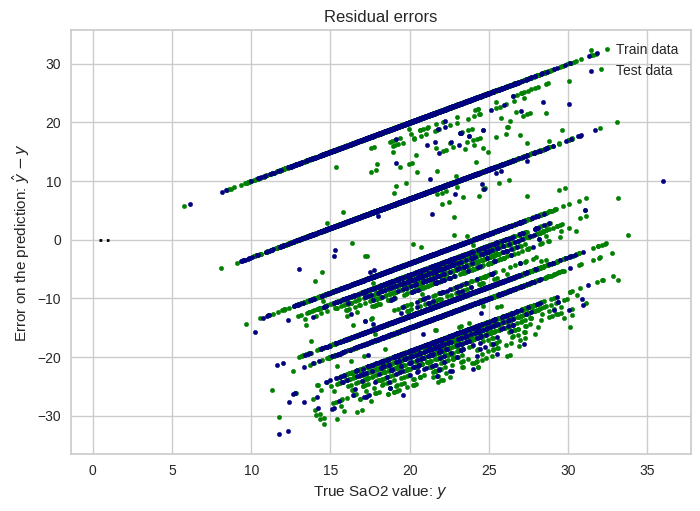

In [ ]:
# create residual error plot
plt.scatter(ridge_pipeline.predict(X_train), ridge_pipeline.predict(X_train) - y_train_r, color = "green", s = 10, label = 'Train data')
plt.scatter(ridge_pipeline.predict(X_test), ridge_pipeline.predict(X_test) - y_test_r,color = "navy", s = 10, label = 'Test data')
plt.hlines(y = 0, xmin = 0.4, xmax = 1, linewidth = 2, color="black", linestyle="dotted")
plt.legend(loc = 'upper right')
plt.title("Residual errors")
plt.xlabel(r"True SaO2 value: $y$")
plt.ylabel(r"Error on the prediction: $\hat y  - y$")
plt.show()


### 3.4 SVM Classification Baseline

For the classification task, you might choose from a wide range of models that you think are most suitable. Here you have the example of the implementation of a Support Vector Machine (SVM).

Before training the model, we need to set a given number of parameters - i.e. hyperparameters - which will be critical in building robust and accurate models. They help us find the balance between bias and variance and thus, prevent the model from overfitting or underfitting.Keep in mind that if you increase the range of hyperparameters to be tested, the training time will increase significantly. If you want more information read [here](https://towardsdatascience.com/hyperparameter-tuning-for-support-vector-machines-c-and-gamma-parameters-6a5097416167).

In [ ]:
# Defining parameter range
param_grid = {'C': [0.1, 100], 
              'gamma': [1, 0.0001],
              'kernel': ['rbf']} 

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(X_train.values, y_train_c.ravel())

cpredictions = grid.predict(X_test.values)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.983 total time=  51.7s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.983 total time=  40.5s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.984 total time=  45.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.984 total time=  44.5s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.983 total time=  52.8s
[CV 1/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.983 total time=  44.3s
[CV 2/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.983 total time=  47.7s
[CV 3/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.984 total time=  42.7s
[CV 4/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.984 total time=  44.3s
[CV 5/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.983 total time=  41.9s
[CV 1/5] END ........C=100, gamma=1, kernel=rbf;, score=0.983 total time= 1.2min
[CV 2/5] END ........C=100, gamma=1, kernel=rbf;,

NameError: ignored

In [ ]:

print('Score: {}'.format(grid.score(X_test.values, y_test_c.ravel())))

Score: 0.9840855726584921


As you can observe, the scoring is almost 100%! Great, right? Well, let's take a closer look at the confusion matrix for a deeper analysis:

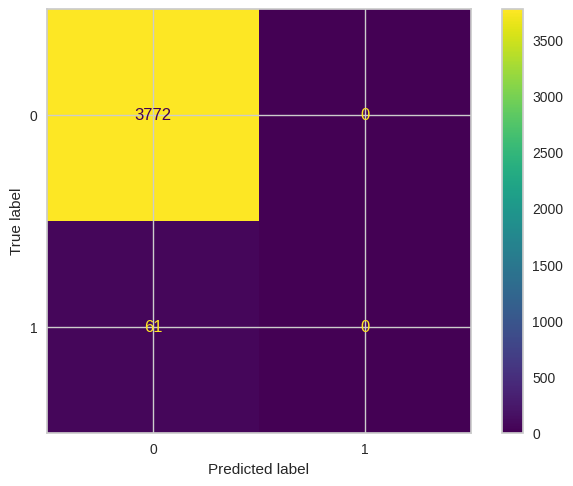

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test_c, cpredictions))
cm_display.plot()
plt.show()

It looks like we have a really imbalanced dataset, where we have only 110 measurements with hidden hypoxia compared to 6073 normal ones. What should we do then?

One can take several approaches when dealing with imbalanced datasets:
- removing the number of datapoints for the majority class to match the number on the minority class. However, this might lead you to loose a lot of information.
- upsample the minority class and generate synthetic data on it, using for example the SMOTE algorithm. This approach has the problem of maintaining the distribution of each variable for that class and might not provide the best results.
- another approach might be to use an algorithm approppriate for this type of data. For that, there is a package very similar to sklearn called [Imbalanced Learn](https://imbalanced-learn.org/stable/) and add the class imbalance to the class_weight parameter in most sklearn algorithms (including in [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)). 

You can read more about it [here](https://medium.com/eni-digitalks/imbalanced-data-an-extensive-guide-on-how-to-deal-with-imbalanced-classification-problems-6c8df0bc2cab).

### 3.5 Your model

Use the insigths learned from the models previously presented to build your own model with the framework you think is most suitable. You are free to use any of the code presented in the notebook.

###### ✏️ Implement your model

In [ ]:
# Code here!
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train[rfe_feature_class], y_train_c)

In [ ]:
# Classification 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn import tree
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_res)
X_test_scaled = scaler.transform(X_test[rfe_feature_class])

# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_res.ravel())

# Make predictions
y_pred_c = model.predict(X_test_scaled)

# Evaluate the model
print('Model accuracy: ', accuracy_score(y_test_c, y_pred_c))
print('Model recall:', recall_score(y_test_c, y_pred_c,average='macro'))
print('Model F1:', f1_score(y_test_c, y_pred_c,average='macro'))


Model accuracy:  0.7633707278893817
Model recall: 0.7184886914799298
Model F1: 0.4735362917508196


In [ ]:
# Classification 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn import tree
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_res)
X_test_scaled = scaler.transform(X_test[rfe_feature_class])

# Train the model
model = tree.DecisionTreeClassifier()
model.fit(X_train_scaled, y_res.ravel())

# Make predictions
y_pred_c = model.predict(X_test_scaled)

# Evaluate the model
print('Model accuracy: ', accuracy_score(y_test_c, y_pred_c))
print('Model recall:', recall_score(y_test_c, y_pred_c,average='macro'))
print('Model F1:', f1_score(y_test_c, y_pred_c,average='macro'))


Model accuracy:  0.9653013305504826
Model recall: 0.5791618135354554
Model F1: 0.5621140606680095


[Text(0.49722663803985817, 0.9848484848484849, 'x[3] <= -0.512\ngini = 0.5\nsamples = 30818\nvalue = [15409, 15409]'),
 Text(0.26560093915628136, 0.9545454545454546, 'x[0] <= 1.134\ngini = 0.316\nsamples = 12984\nvalue = [10431, 2553]'),
 Text(0.1544650211287781, 0.9242424242424242, 'x[0] <= -1.371\ngini = 0.399\nsamples = 8969\nvalue = [6505, 2464]'),
 Text(0.061166022059876805, 0.8939393939393939, 'x[2] <= -0.823\ngini = 0.126\nsamples = 4495\nvalue = [4192, 303]'),
 Text(0.017476006302821947, 0.8636363636363636, 'x[14] <= -1.115\ngini = 0.449\nsamples = 462\nvalue = [305, 157]'),
 Text(0.004583870505658215, 0.8333333333333334, 'x[6] <= 0.811\ngini = 0.357\nsamples = 168\nvalue = [39, 129]'),
 Text(0.0022919352528291076, 0.803030303030303, 'gini = 0.0\nsamples = 27\nvalue = [27, 0]'),
 Text(0.006875805758487323, 0.803030303030303, 'x[13] <= 0.108\ngini = 0.156\nsamples = 141\nvalue = [12, 129]'),
 Text(0.004583870505658215, 0.7727272727272727, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]

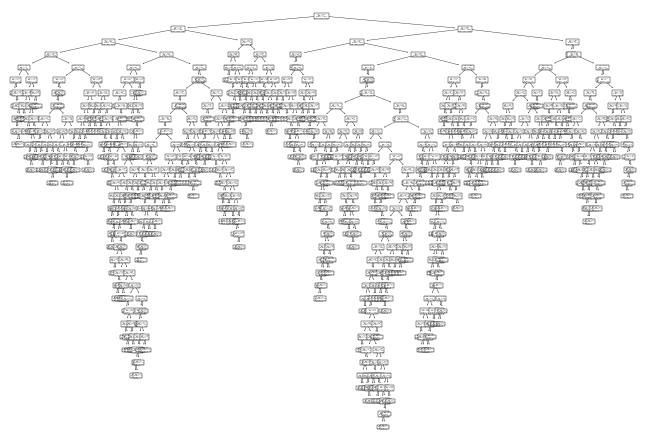

In [ ]:
tree.plot_tree(model)

In [ ]:
X_train[rfe_feature_class]

,SpO2,height,FiO2,sofa_resp,hematocrit,mch,mchc,rbc,thrombin,creatinine,potassium,ph,heart_rate,delta_mbp,resp_rate
0,2.0,21.0,10.0,2.0,165.0,87.0,43.0,186.0,96.0,11.0,38.0,52.0,114.0,22.0,20.0
1,12.0,21.0,15.0,1.0,150.0,143.0,89.0,155.0,96.0,10.0,20.0,47.0,128.0,22.0,9.0
2,0.0,64.0,10.0,2.0,148.0,106.0,49.0,152.0,96.0,4.0,24.0,52.0,135.0,0.0,17.0
3,0.0,64.0,10.0,2.0,100.0,111.0,53.0,101.0,96.0,4.0,22.0,60.0,5.0,29.0,28.0
4,12.0,51.0,23.0,3.0,168.0,126.0,82.0,184.0,96.0,8.0,30.0,46.0,126.0,1.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19495,8.0,12.0,0.0,2.0,240.0,104.0,84.0,297.0,40.0,11.0,23.0,43.0,10.0,67.0,13.0
19496,12.0,12.0,15.0,2.0,183.0,103.0,93.0,252.0,40.0,11.0,21.0,58.0,125.0,22.0,13.0
19497,9.0,24.0,15.0,2.0,29.0,94.0,56.0,42.0,96.0,9.0,21.0,44.0,8.0,69.0,36.0
19498,0.0,34.0,15.0,1.0,154.0,86.0,57.0,190.0,96.0,6.0,22.0,48.0,108.0,0.0,17.0


In [ ]:
rfe

## 4. Model Evaluation

To be able to develop an ML model for the recalibration of SpO2 levels and implement it in a clinical setting, it is crucial to properly evaluate its performance in the task that is supposed to do.

A set of performance metrics should be carefully chosen, considering the clinical setting where the model will be aplied in but also the dataset where is what trained on:
- If the dataset contains mostly one racial group, how will it perform on others patients?
- Does the dataset have patients from a wide range of ages or is it more focused on a narrow range?

### 4.1 Performance Metrics

#### Regression Model

Regression tasks are often evaluated using the [$R^2$ score](https://en.wikipedia.org/wiki/Coefficient_of_determination). The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). In the general case when the true y is non-constant, a constant model that always predicts the average y disregarding the input features would get a $R^2$ score of 0.0.

In [ ]:
# Evaluate the linear model with R2 :
y_pred_train = lpipeline.predict(X_train.values)
linear_train_r2 = r2_score(y_train_r, y_pred_train)
print(f'Linear model R2 score: {linear_train_r2}')

# Evaluate the ridge model with R2 :
y_pred_train = ridge_pipeline.predict(X_train.values)
ridge_train_r2 = r2_score(y_train_r, y_pred_train)
print(f'R2 score: {ridge_train_r2}')

✏️ Different regression metrics are [implemented by sklearn](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics). Try another metric that you think is relevant to this problem.

In [ ]:
# CODE here ! 

We saw that the regression metrics of both the linear regression and the regularized linear ridge regressions are not very satisfying. There are two explanations: either, we have not the proper variables to explain the output variables or these variables do not relate to the SaO2 with a pure linear relationship.   

✏️  Can you fit and evaluate a better regression model in term of $R^2$ ? Consider for example [decision trees](https://scikit-learn.org/stable/modules/tree.html#regression) or [ensemble models](https://scikit-learn.org/stable/modules/ensemble.html). But feel free to experiment with any other type of regression algorithms ! 

In [ ]:
# Code here !

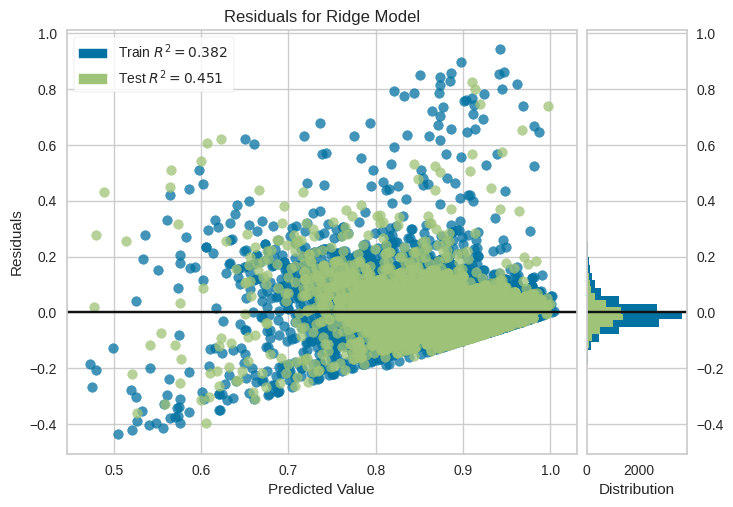

<Axes: title={'center': 'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [ ]:
visualizer = ResidualsPlot(ridge_pipeline)
visualizer.fit(X_train_processed.values, y_train_r)
visualizer.score(X_test_processed.values, y_test_r)
visualizer.show()

R2 score: 0.45085480507679765


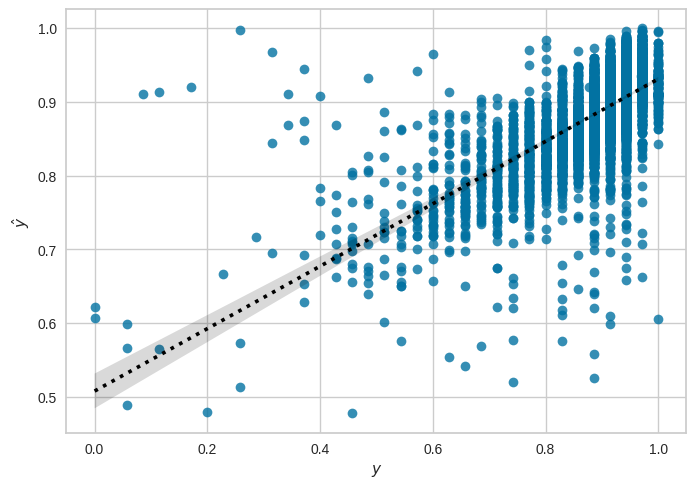

In [ ]:
ridge_pipeline.fit(X_train_processed.values, y_train_r)
hat_y_test = ridge_pipeline.predict(X_test_processed.values)

fig, ax = plt.subplots(1)
sns.regplot(data=None, x=y_test_r, y=hat_y_test, line_kws={"color":"black", "linestyle":"dotted"})
plt.plot()
ax.set(xlabel=r"$y$", ylabel=r"$\hat y$")
test_r2_score_ = r2_score(y_test_r, hat_y_test)
print(f"R2 score: {test_r2_score_}")

#### Classification Model

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


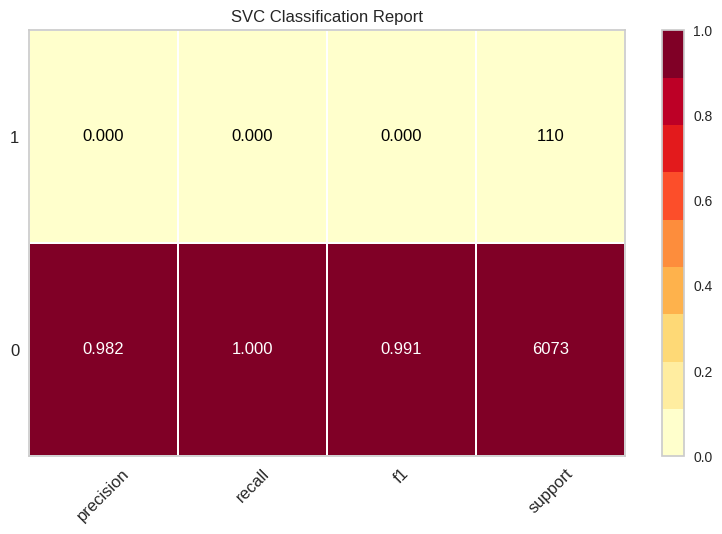

<Axes: title={'center': 'SVC Classification Report'}>

In [ ]:
#Instantiate the classification model and visualizer
visualizer = ClassificationReport(SVC(), classes=[0,1], support=True)

visualizer.fit(X_train_processed.values, y_train_c.ravel())        # Fit the visualizer and the model
visualizer.score(X_test_processed.values, y_test_c.ravel())        # Evaluate the model on the test data
visualizer.show()       

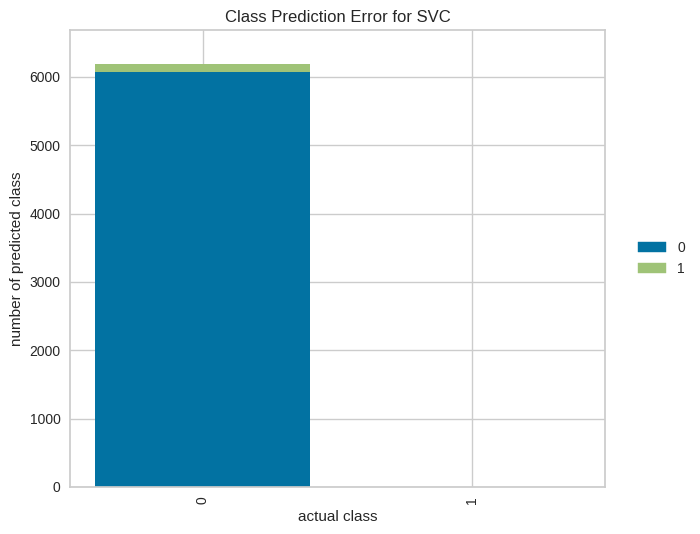

In [ ]:
visualizer = ClassPredictionError(
    SVC(), classes=[0,1])
visualizer.fit(X_train_processed.values, y_train_c.ravel())
visualizer.score(X_test_processed.values, y_test_c.ravel())
visualizer.show();

#### ✏️ Properly evaluate your model

In [ ]:
# Code here!

### 4.2 Feature Importance

Compute the SHAP values for the test data

In [ ]:
grid.best_estimator_

SVC(C=0.1, gamma=1)

In [ ]:
best_predictor=SVC(C=0.1, gamma=1).fit(X_train_processed, y_train_c.ravel())

In [ ]:
explainer = shap.KernelExplainer(best_predictor.predict, X_train_processed)
shap_values = explainer.shap_values(X_test_processed.values)

X does not have valid feature names, but SVC was fitted with feature names


  0%|          | 0/6183 [00:00<?, ?it/s]

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names


Plot the SHAP values for each feature

In [ ]:
fig, ax = plt.subplots(figsize=(6, 8))
shap.plots.beeswarm(shap_values, max_display=10, show=False)
plt.title("Feature Importance: SHAP Values for Top 10 Features", fontsize=14)
plt.tight_layout()
plt.show()

NameError: ignored

Plot the most important features

In [ ]:
fig, ax = plt.subplots(figsize=(6, 8))
shap.plots.bar(shap_values, max_display=10, show=False)
plt.tight_layout()